# Kaggle - COVID19 Global Forecasting (Week 1-2) 

## Submission 
<p>For each ForecastId in the test set, you'll predict the cumulative COVID-19 cases and fatalities to date. The file should contain a header and have the following format:<br>

ForecastId,ConfirmedCases,Fatalities<br>
1,10,0<br>
2,10,0<br>
3,10,0<br>
etc.<br>
You will get the ForecastId for the corresponding date and location from the test.csv file.</p>
1. Submissions are evaluated using the column-wise root mean squared logarithmic error.(RMSLE)
2. R^2 Is absolutely Useless as most scores are correctly predicted as 0.

## TO DO:

1. Fix Data Leak due to overlapping dates in train, test. (Done)
2. Fix XGBoost order of test set columns different error. (Done)
3. Create Functions - for total cases by country on a particular day. - Country wise total cases.(Done)
4. Plot cases on map.
5. Explore Logistic Curves and Growth Factors. (Done)
5. Predicitions using Logistics curve ?
6. Lets do Predictions country wise - write function that gets dataframe for a particular country, runs model for just that country.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
np.set_printoptions(threshold=sys.maxsize)

In [2]:
path_train = 'covid19-global-forecasting-week-2/train.csv'
path_test = 'covid19-global-forecasting-week-2/test.csv'
path_sbumit = 'covid19-global-forecasting-week-2/submission.csv'

train_kaggle = '/kaggle/input/covid19-global-forecasting-week-1/train.csv'
test_kaggle = '/kaggle/input/covid19-global-forecasting-week-1/test.csv'
submit_kaggle = '/kaggle/input/covid19-global-forecasting-week-1/submission.csv'

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)
submission = pd.read_csv(path_sbumit)

#### Rename Columns to Week 1 Format 

In [11]:
df_train.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)

In [12]:
df_test.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)

## EDA

## About the Data 
1. Contains Daily Reports of Number of Cases and Fatalities for countries.
2. [Missing Data]Contains some entries with Province/State Information Missing - Dropped.
3. Contains latitude and longitude for entries, Can Plot on map.
4. Date - 22nd Feb to 23nd March. (Getting Updated On kaggle)
5. Country/Region - 163

In [13]:
# Dataset Dimesnions
print('Train shape', df_train.shape)
print('Test shape', df_test.shape)
# Missing/Null Values
print('\nTrain Missing\n', df_train.isnull().sum())
print('\nTest Missing\n', df_test.isnull().sum())

Train shape (18816, 6)
Test shape (12642, 4)

Train Missing
 Id                    0
Country/Region        0
Province/State    10816
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

Test Missing
 ForecastId           0
Country/Region       0
Province/State    7267
Date                 0
dtype: int64


### Unique countries in the dataset 

In [14]:
lst = df_train['Country/Region'].unique()
#print('Total_Countries\n:', len(lst))
#for i in lst:
#    print(i)

### Date Range for the Dataset 

In [15]:
print(df_train['Date'].min(), ' - ', df_train['Date'].max())

2020-01-22  -  2020-03-25


### Checking Daily Worldwide Confirmed Cases and Fatalities 

In [16]:
# GroupBy syntax (columns to group by in list)[Columns to aggregate, apply function to] . aggregation functions on it 
train_cases_conf = df_train.groupby(['Date'])['ConfirmedCases'].sum()
#train_cases_conf

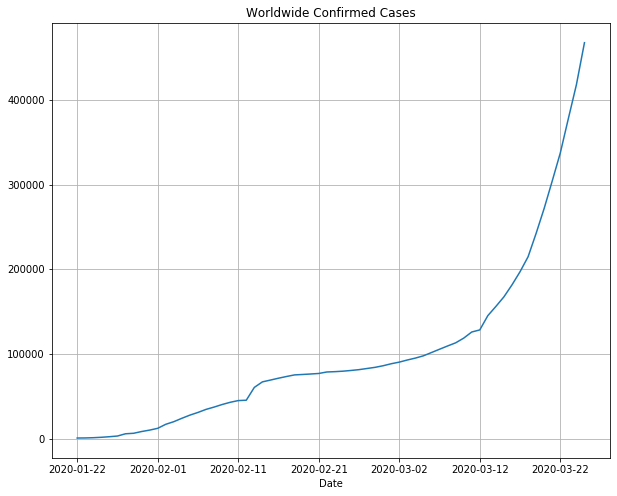

In [17]:
train_cases_conf.plot(figsize = (10,8), title = 'Worldwide Confirmed Cases', grid = True)

#### Worldwide Confirmedcases On Log axis

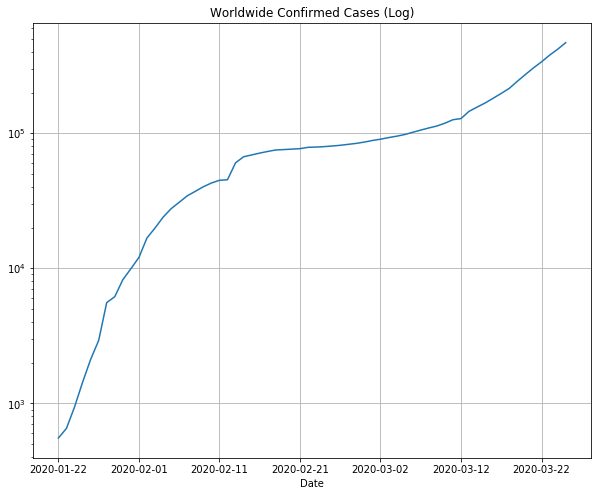

In [18]:
train_cases_conf.plot(figsize = (10,8), title = 'Worldwide Confirmed Cases (Log)', grid = True, logy = True)

In [19]:
train_fatal = df_train.groupby(['Date'])['Fatalities'].sum()
#train_fatal

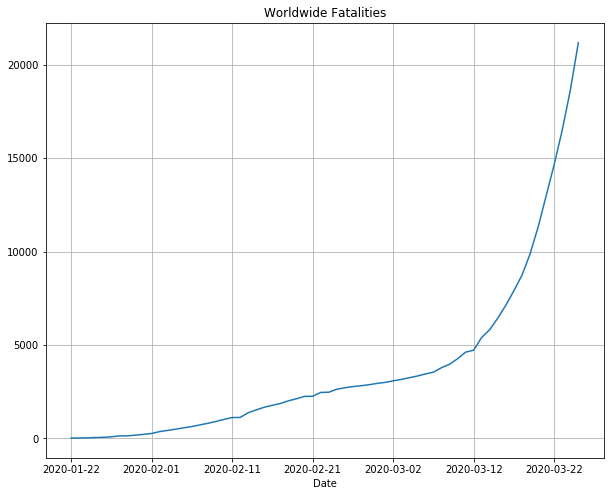

In [20]:
train_fatal.plot(figsize = (10,8), title = 'Worldwide Fatalities', grid = True)

### Check Confirmed cases and fatalities for a 'Country' or 'World'

Duration : 0.09208011627197266 seconds


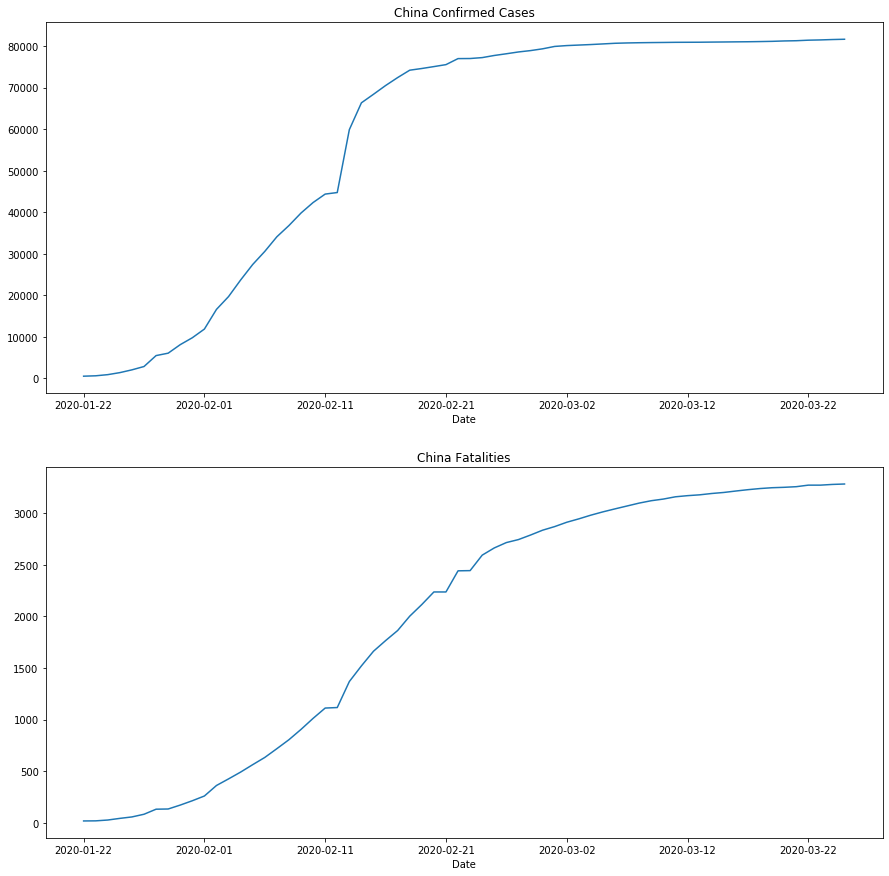

In [21]:
# To DO :
# 1. Add option to check for World or Country (Done)
# 2. Add toggle for scale = "linear", "log"
# 3. Check if country is present in Dataset, else throw error.

def country_stats(country, df):
    if country != 'World':
        country_filt = (df['Country/Region'] == country)
        df_cases = df.loc[country_filt].groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.loc[country_filt].groupby(['Date'])['Fatalities'].sum()
    else:
        df_cases = df.groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.groupby(['Date'])['Fatalities'].sum()
        
    fig, axes = plt.subplots(nrows = 2, ncols= 1, figsize=(15,15))
    axes[0].set_title(country + ' Confirmed Cases')
    axes[1].set_title(country + ' Fatalities')
    df_cases.plot(ax = axes[0])
    df_fatal.plot(ax = axes[1])
    

start = time.time()    
country_stats('China', df_train)
print('Duration : {} seconds'.format(time.time() - start))

#### Fatalities and Confirmed Cases by Country (Log Scale)
We can observe how different countries are testing:
1. Countries like Iran have both the curves starting off very close, indicating they only started testing when people were dying/near death.
2. Looking at the sharp initial increase in cases for countries like US shows that widespread testing perhaps started too late.

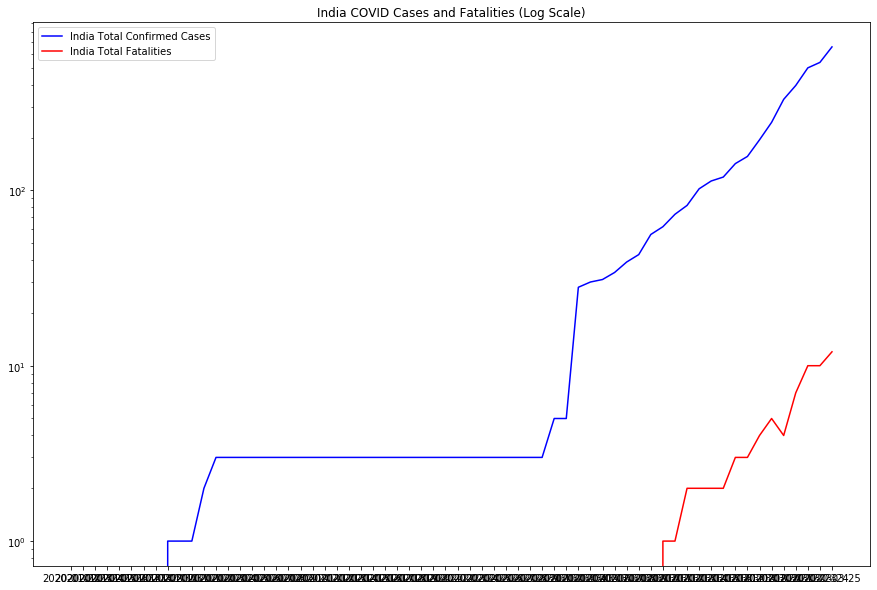

In [22]:
# grouping using same Country filter to get fatalities on each date (grouped by date)
# groupby([list of columns to groupby]) [which columns to apply aggregate fx to ]. (aggregate function)
# To Do - Fix Ticks 

def country_stats_log(country, df):
    count_filt =(df_train['Country/Region'] == country)
    df_count_case = df_train.loc[count_filt].groupby(['Date'])['ConfirmedCases'].sum()
    df_count_fatal = df_train.loc[count_filt].groupby(['Date'])['Fatalities'].sum()
    plt.figure(figsize=(15,10))
    plt.axes(yscale = 'log')
    plt.plot(df_count_case.index, df_count_case.tolist(), 'b', label = country +' Total Confirmed Cases')
    plt.plot(df_count_fatal.index, df_count_fatal.tolist(), 'r', label = country +' Total Fatalities')
    plt.title(country +' COVID Cases and Fatalities (Log Scale)')
    plt.legend()
    

country_stats_log('India', df_train)

###  Most Affected Countries 


#### No. of cumulative cases till a Particular Day

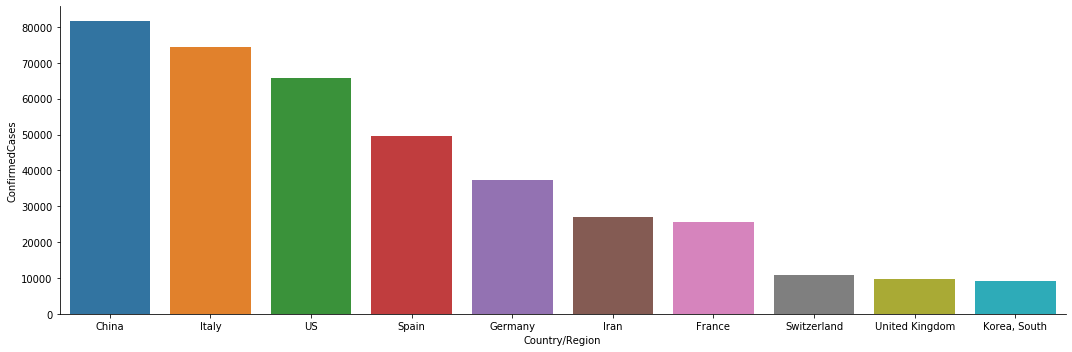

In [23]:
# as_index = False to not make the grouping column the index, creates a df here instead of series, preserves
# Confirmedcases column

# Confirmed Cases till a particular day by country

def case_day_country (Date, df):
    df = df.groupby(['Country/Region', 'Date'], as_index = False)['ConfirmedCases'].sum()
    date_filter = (df['Date'] == Date)
    df = df.loc[date_filter]
    df.sort_values('ConfirmedCases', ascending = False, inplace = True)
    sns.catplot(x = 'Country/Region', y = 'ConfirmedCases' , data = df.head(10), height=5,aspect=3, kind = 'bar')
    
    
case_day_country('2020-03-25', df_train)

### Change in Cases for a day. (Top 10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


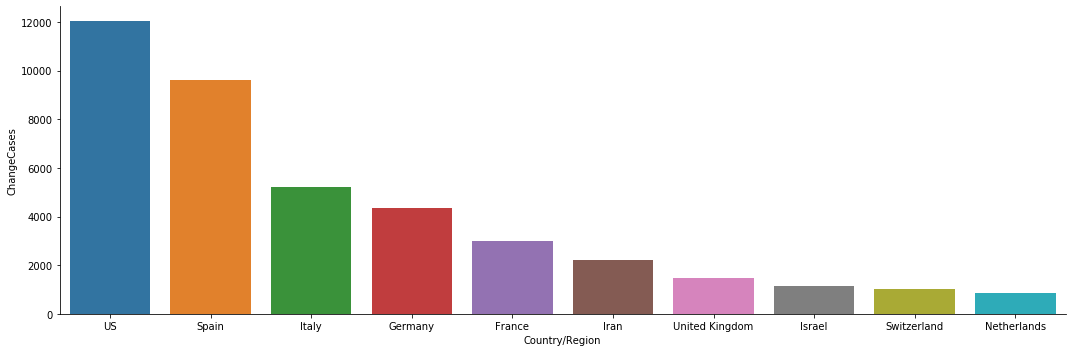

In [24]:
def case_country_diff (Date, df):
    
    df = df.groupby(['Country/Region', 'Date'], as_index = False)['ConfirmedCases'].sum()
    
    # Creating the two filter for date + dateoffset(1)
    date_filter = (df['Date'] == Date)
    # Getting filter for previous day 
    arr_date = Date.split('-')
    arr_date[2] = str(int(arr_date[2]) - 1) 
    new_date = '-'.join(arr_date)
    date_filter_2 = (df['Date'] == new_date)
    
    # Creating the two dataframes for the dates
    # Have to reset index, groupby screwed them up.
    df_1 = df.loc[date_filter]
    df_1.reset_index(drop= True, inplace = True)
    df_2 = df.loc[date_filter_2]
    df_2.reset_index(drop= True, inplace = True)
    
    # Getting change in Cases 
    df_1['ChangeCases'] = df_1['ConfirmedCases'] - df_2['ConfirmedCases']
    df_1.sort_values('ChangeCases', ascending = False, inplace = True)
    sns.catplot(x = 'Country/Region', y = 'ChangeCases' , data = df_1.head(10), height=5,aspect=3, kind = 'bar')


case_country_diff('2020-03-25', df_train)

# Logistic Curve or Sigmoid/ S- shaped Curve : Comparing Epidemic Behaviour
<p>From 3blue1brown video, most epidemics follow a logistic curve. The no. of infected rises exponentially and reaches an inflection point before steeply decreasing. This can be somewhat seen in China's Confirmed Cases plot.</p>
![Image of Sigmoid](https://wikimedia.org/api/rest_v1/media/math/render/svg/9e26947596d387d045be3baeb72c11270a065665)
Here x0 = the x value of the sigmoids midpoint. <br>
L = the curve's maximum value. <br>
k = the logistic growth rate or steepness of the curve.

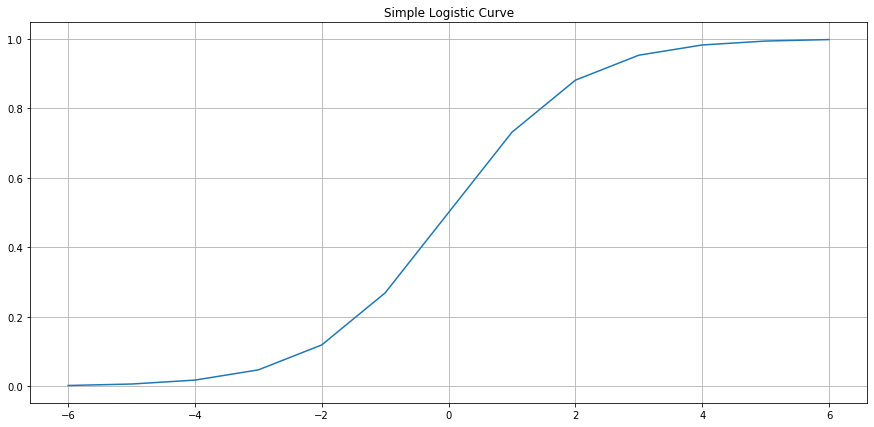

In [25]:
# Plotting a simple logistic curve using numpy and matplotlib.
# x = (-6,6), L =1, k = 1, x0 =0



x = np.arange(-6,7)
power = -1*x
y = 1 / (1 + np.exp(power))

plt.figure(figsize=(15,7))
plt.title('Simple Logistic Curve')
plt.grid(True)
plt.plot(x, y)
plt.show()

#### Compare Growth of Covid19 Cases and Fatalitis to Logistic Curve
<p>As we can see China's growth curve resembles the logistic function, many other countries have not hit the inflection point.</p>

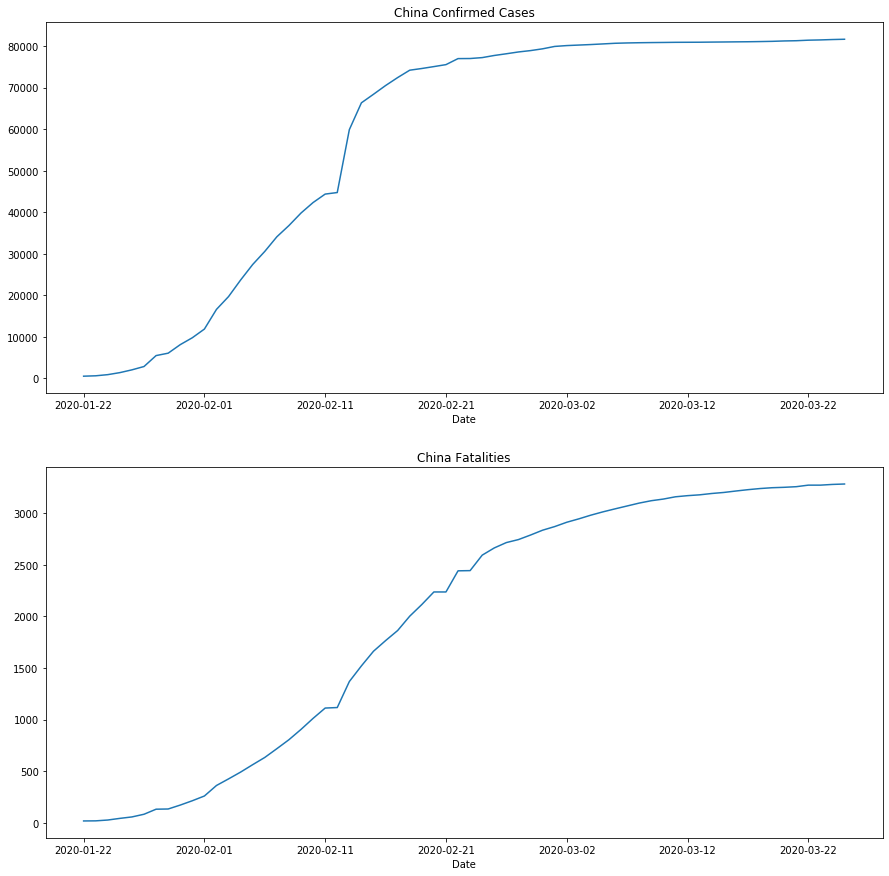

In [26]:
country_stats('China', df_train)

### Growth Factor
<p> The growth factor is the ratio between the number of cases on one day and the number of cases the precious day. 
    Measure of whether the disease is growing or not. 
    1. A value of greater than 1 = growth. 
    2. Less than 1 = decline. 
    3. A growth factor of 1 is the inflection point and at this point the disease is not increasing.
It can be seen that the disease hasn't stabilised at the inflection point.

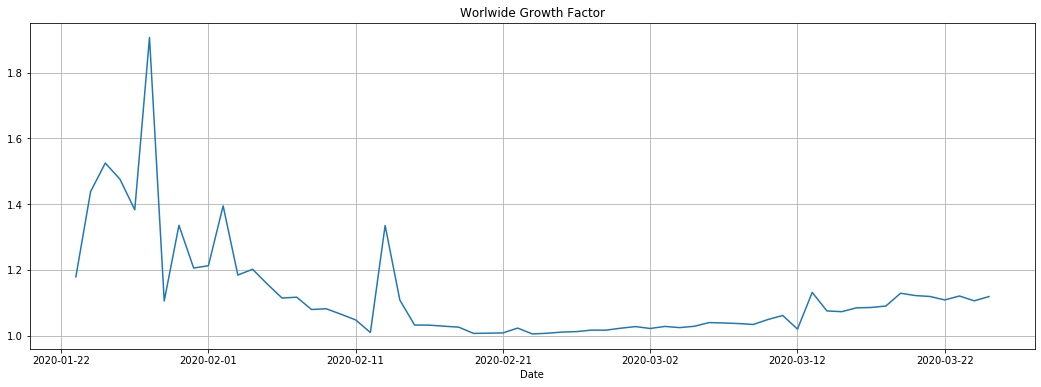

In [27]:
# pandas df.shift to shift dataframe

# Getting Worldwide Growth Factor
# GF = cases on date/ cases on day -1

growth_factor = train_cases_conf/train_cases_conf.shift(1)
growth_factor.plot(grid = True, title = 'Worlwide Growth Factor', figsize = (18,6))

# Data Wrangling/ Pre-processing/ Cleaning 
1. Identifying and Handling missing values.
2. Data Formating.
3. Data Normalization(centering and scaling).
4. Data bining.
5. Turning categorical values into numerical values.

### Need to Exclude Leaky Data, the same Dates are in both train and test set.
1. First convert object to python datetime type <br>
Using pd.to_datetime() <br>
Check Getting converted to float, because haven't converted to date before comparison, still object.

In [28]:
df_train.Date = pd.to_datetime(df_train['Date'])
df_test.Date = pd.to_datetime(df_test['Date'])
print(df_train['Date'].max())
print(df_test['Date'].min())

2020-03-25 00:00:00
2020-03-19 00:00:00


### Lets truncate df_train by date < df_test['Date'].min()

In [29]:
date_filter = df_train['Date'] < df_test['Date'].min()
df_train = df_train.loc[date_filter]

In [30]:
# Dropping ID and getting rid of Province/State with NULL values 
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16758 entries, 0 to 18808
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              16758 non-null  int64         
 1   Country/Region  16758 non-null  object        
 2   Province/State  7125 non-null   object        
 3   Date            16758 non-null  datetime64[ns]
 4   ConfirmedCases  16758 non-null  float64       
 5   Fatalities      16758 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 916.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12642 entries, 0 to 12641
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ForecastId      12642 non-null  int64         
 1   Country/Region  12642 non-null  object        
 2   Province/State  5375 non-null   object        
 3   Date            1264

In [31]:
# lets get Cumulative sum of ConfirmedCases and Fatalities for each country on each data (same as original data)
# Doing to create copy without ID and 

train_country_date = df_train.groupby(['Country/Region', 'Date'], as_index=False)['ConfirmedCases', 'Fatalities'].sum()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [32]:
#df_train.drop(['Id', 'Province/State'], axis = 1, inplace = True)

In [33]:
#train_country_date = df_train

In [34]:
print(train_country_date.info())
print(train_country_date.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9861 entries, 0 to 9860
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country/Region  9861 non-null   object        
 1   Date            9861 non-null   datetime64[ns]
 2   ConfirmedCases  9861 non-null   float64       
 3   Fatalities      9861 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 385.2+ KB
None
Country/Region    0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64


### Feature Engineering
Splitting Date into day, month, day of week. <br>
Check if Date is in python datetime format. Else, convert object to python datetime type <br>
Using pd.to_datetime()

#### Using Pandas Series.dt.month
The month as January=1, December=12.

In [35]:
# Adding day, month, day of week columns 

train_country_date['Month'] = train_country_date['Date'].dt.month
train_country_date['Day'] = train_country_date['Date'].dt.day
train_country_date['Day_Week'] = train_country_date['Date'].dt.dayofweek
train_country_date['quarter'] = train_country_date['Date'].dt.quarter
train_country_date['dayofyear'] = train_country_date['Date'].dt.dayofyear
train_country_date['weekofyear'] = train_country_date['Date'].dt.weekofyear

In [36]:
train_country_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9861 entries, 0 to 9860
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country/Region  9861 non-null   object        
 1   Date            9861 non-null   datetime64[ns]
 2   ConfirmedCases  9861 non-null   float64       
 3   Fatalities      9861 non-null   float64       
 4   Month           9861 non-null   int64         
 5   Day             9861 non-null   int64         
 6   Day_Week        9861 non-null   int64         
 7   quarter         9861 non-null   int64         
 8   dayofyear       9861 non-null   int64         
 9   weekofyear      9861 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 847.4+ KB


#### Same Feature Engineering for Test Set

In [37]:
# First drop Province/State
df_test.drop('Province/State', axis = 1, inplace = True)

In [38]:
# adding Month, DAy, Day_week columns Using Pandas Series.dt.month

df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test['Day_Week'] = df_test['Date'].dt.dayofweek
df_test['quarter'] = df_test['Date'].dt.quarter
df_test['dayofyear'] = df_test['Date'].dt.dayofyear
df_test['weekofyear'] = df_test['Date'].dt.weekofyear

In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12642 entries, 0 to 12641
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ForecastId      12642 non-null  int64         
 1   Country/Region  12642 non-null  object        
 2   Date            12642 non-null  datetime64[ns]
 3   Month           12642 non-null  int64         
 4   Day             12642 non-null  int64         
 5   Day_Week        12642 non-null  int64         
 6   quarter         12642 non-null  int64         
 7   dayofyear       12642 non-null  int64         
 8   weekofyear      12642 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 889.0+ KB


#### Councatenating Train-Test to Label encode Country/Region Categorical Variable.
1. Make copy of train data without Confirmed Cases and Fatalities. Index - 0 to 17608
2. Concatenate train, test.
3. Label Encode Countries.
4. Add back Cofirmed Cases, Fatalities columns to clean_train_data.
5. Modelling
6. Saving Predicted Values with ForecastID

In [40]:
# train_country_date
# df_test
# Lets select the Common Labels and concatenate.

labels = ['Country/Region', 'Date', 'Month', 'Day', 'Day_Week','quarter', 'dayofyear', 'weekofyear']

df_train_clean = train_country_date[labels]
df_test_clean = df_test[labels]

data_clean = pd.concat([df_train_clean, df_test_clean], axis = 0)

In [41]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22503 entries, 0 to 12641
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country/Region  22503 non-null  object        
 1   Date            22503 non-null  datetime64[ns]
 2   Month           22503 non-null  int64         
 3   Day             22503 non-null  int64         
 4   Day_Week        22503 non-null  int64         
 5   quarter         22503 non-null  int64         
 6   dayofyear       22503 non-null  int64         
 7   weekofyear      22503 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 1.5+ MB


## Preparing Data For Models - One- Hot Encode Country

In [ ]:
len(data_clean['Country/Region'].unique())

In [ ]:
data_clean_1 = data_clean

In [ ]:
data_clean_1.info()

In [ ]:
data_cat = pd.get_dummies(data_clean_1['Country/Region'])

In [ ]:
data_merged = pd.concat([data_clean_1, data_cat], axis = 1)

In [ ]:
data_merged.info()

In [ ]:
data_clean_1 = data_merged

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Label Encoder for Countries 

enc = LabelEncoder()
data_clean['Country'] = enc.fit_transform(data_clean['Country/Region'])
data_clean

In [ ]:
# Dropping Country/Region and Date
data_clean_1.drop(['Country/Region', 'Date'], axis = 1, inplace=True)

### Splitting Back into Train and Test

In [ ]:
data_clean_1.shape

In [ ]:
train_country_date.shape

In [ ]:
index_split = train_country_date.shape[0]
data_train_clean = data_clean_1[:index_split]

In [ ]:
data_test_clean = data_clean_1[index_split:]

In [ ]:
data_train_clean.info()

### Adding Back Confirmed Cases and Fatalities
Using original df_train, check shape is same, head, tail have same values. ORDER NEEDS TO BE SAME.

### Creating Features and Two Labels

In [ ]:
x = data_train_clean
y_case = train_country_date['ConfirmedCases']
y_fatal = train_country_date['Fatalities']

### Train-Test Split - Confirmed Cases

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y_case, test_size = 0.3, random_state = 42)

### Train-Test Split - Fatalities

In [ ]:
from sklearn.model_selection import train_test_split

x_train_fatal, x_test_fatal, y_train_fatal, y_test_fatal = train_test_split(x, y_fatal, test_size = 0.3, random_state = 42)

## Modeling - Regression Problem 
Using features Country/Region, Lat, Long, Month, Day, Day_week, quarter, dayofyear, weekofyear.<br>
To predict ConfirmedCases, Fatalities.
### To predict 2 Different Target Variables, Train two classifiers, one for each.

# Modelling
1. Linear Regression - Worse than baseline model. 
2. Logistic Regression (Will need GridSearchCV for Max_iter) - Absolute Trash.
3. Polynomial Regression - Not Tried
4. SVM Regressor - Very bad performance with a poly kernel and some variation of c and eta. (read up more)
4. RandomForest Regressor - Gives 1.7 RMSE, With data leak removed gives - 2.18417 RMSE.
5. GradientBoost Regressor - Gives slightly lower performance than RF

### Country Wise Modelling

#### Simple Linear Model.

In [322]:
df_train_count = pd.read_csv(path_train)
df_test_count = pd.read_csv(path_test)
df_train_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)
df_test_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)

In [364]:
def country_df(country, df):
    if country != 'World':
        country_filt = (df['Country/Region'] == country)
        df_cases = df.loc[country_filt].groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.loc[country_filt].groupby(['Date'])['Fatalities'].sum()
    else:
        df_cases = df.groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.groupby(['Date'])['Fatalities'].sum()
    
    return df_cases, df_fatal
   

india_cases_train, india_fatal_train = country_df('India', df_train_count)

In [366]:
# train data for china 

china_cases_train, china_fatal_train = country_df('China', df_train_count)

In [368]:
# Getting test data for china 
country_filt = (df_test_count['Country/Region'] == 'China')
china_test = df_test_count.loc[country_filt, ['Date']]

In [369]:
china_test = china_test['Date']

In [324]:
country_filt = (df_test_count['Country/Region'] == 'India')
india_test = df_test_count.loc[country_filt, ['Date']]

In [325]:
india_test = india_test['Date']

### Simple Linear Fit

In [327]:
india_cases_str = india_cases_train.index.to_series()
india_cases_str = pd.to_datetime(india_cases_str)

In [328]:
india_cases = india_cases_train.index.to_series()

In [362]:
#df['date_ordinal'] = pd.to_datetime(df['date']).apply(lambda date: date.toordinal())

date_ordinal = india_cases_str.apply(lambda date: date.toordinal())

[Text(0, 0, '2020-01-22 00:00:00'),
 Text(0, 0, '2020-01-23 00:00:00'),
 Text(0, 0, '2020-01-24 00:00:00'),
 Text(0, 0, '2020-01-25 00:00:00'),
 Text(0, 0, '2020-01-26 00:00:00'),
 Text(0, 0, '2020-01-27 00:00:00'),
 Text(0, 0, '2020-01-28 00:00:00')]

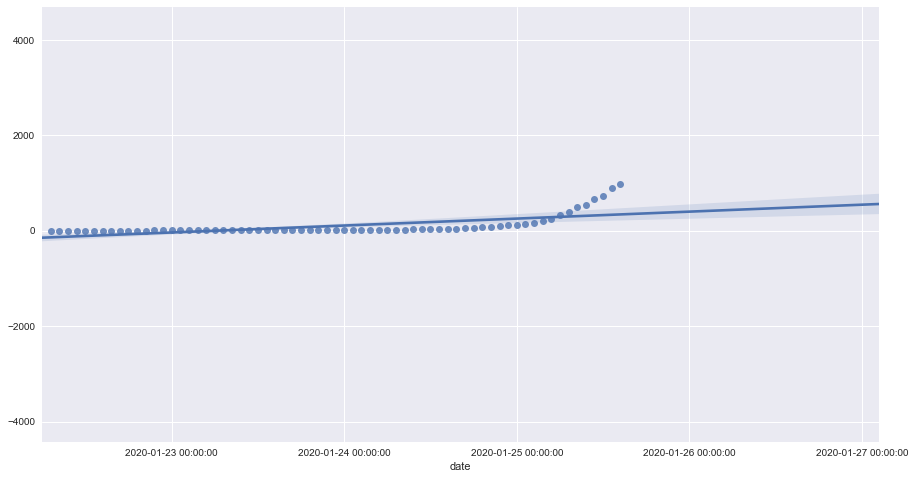

In [363]:
plt.figure(figsize=(15,8))
ax = sns.regplot(x = date_ordinal ,y = india_cases_train.to_list())
ax.set_xlim(date_ordinal.min() - 1, date_ordinal.max() + 30)
ax.set_xlabel('date')
new_labels = india_cases_str.to_list()
ax.set_xticklabels(new_labels)

### Logistic Regression

In [330]:
# india_cases_train, india_fatal_train
# india_test
india_test_x = india_test.to_list()

In [331]:
len(india_test_x)

43

In [332]:
india_cases_train_x = india_cases_train.index.to_list()

In [333]:
y_cases = india_cases_train.to_list()

In [334]:
y_fatal = india_fatal_train.to_list()

#### Preparing Data 

In [87]:
from sklearn.preprocessing import LabelEncoder

In [88]:
lab_enc = LabelEncoder()

In [337]:
x_train = lab_enc.fit_transform(india_cases_train_x)

In [338]:
x_test = [x for x in range(85)]
x_test = np.asarray(x_test)

#### Logistic Regression

In [285]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1250)
log_reg.fit(x_train.reshape(-1,1), y_cases)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1250,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [286]:
log_reg.score(x_train.reshape(-1,1), y_cases)

0.8125

In [287]:
y_hat = log_reg.predict(x_train.reshape(-1,1))

In [288]:
y_hat_future = log_reg.predict(x_test.reshape(-1,1))

In [289]:
y_hat_future 

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
         3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
         3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
         3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   5.,   5.,
         5.,   5.,  39.,  43.,  56.,  62.,  73.,  82., 102., 113., 119.,
       142., 156., 194., 330., 396., 499., 657., 657., 657., 657., 657.,
       657., 657., 657., 657., 657., 657., 657., 657., 657., 657., 657.,
       657., 657., 657., 657., 657., 657., 657., 657.])

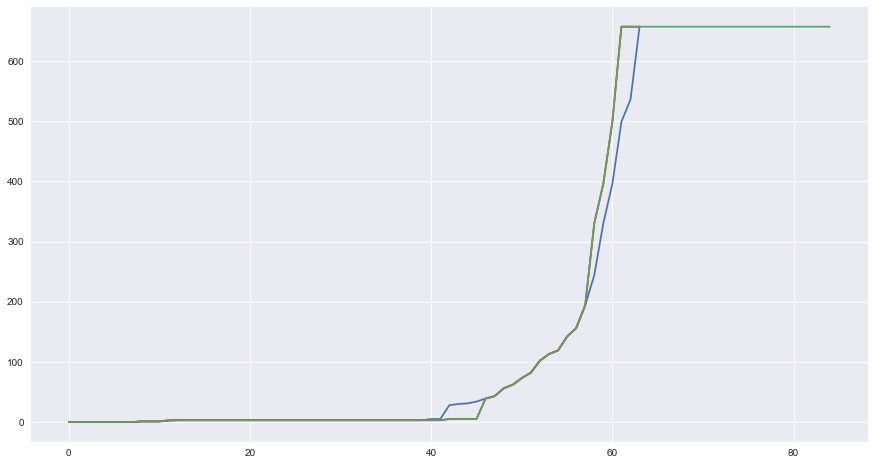

In [290]:
plt.figure(figsize=(15,8))
plt.plot(y_cases)
plt.plot(y_hat, 'r')
plt.plot(y_hat_future)

### Polynomial Regression

In [341]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [342]:
x_train_poly = PolynomialFeatures(degree= 5).fit_transform(x_train.reshape(-1,1))
x_test_poly = PolynomialFeatures(degree= 5).fit_transform(x_test.reshape(-1,1))

#### China

In [370]:
china_cases_train_x = china_cases_train.index.to_list()

y_cases_china = china_cases_train.to_list()

y_fatal_china = china_fatal_train.to_list()

In [371]:
x_train_poly_china = PolynomialFeatures(degree= 5).fit_transform(x_train.reshape(-1,1))
x_test_poly_china = PolynomialFeatures(degree= 5).fit_transform(x_test.reshape(-1,1))

In [373]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_poly, y_cases_china)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [374]:
lin_reg.score(x_train_poly, y_cases_china)

0.9932903690735988

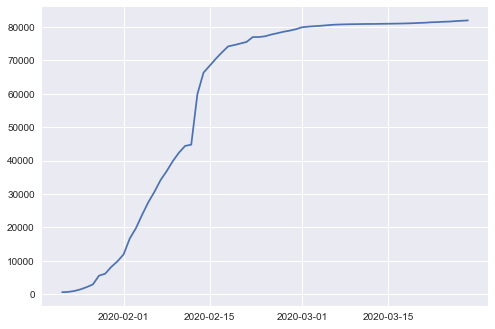

In [378]:
plt.plot_date(d , y_cases_china, label = 'Actual Values', linestyle = 'solid', marker = None)

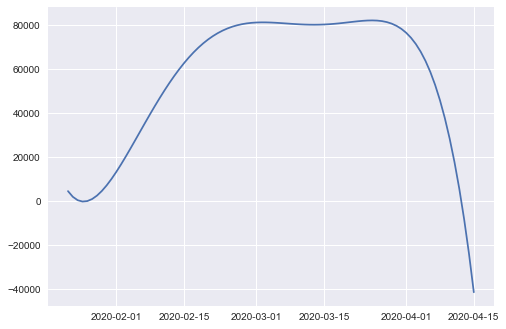

In [379]:
plt.plot_date(d_1 , lin_reg.predict(x_test_poly), label = 'Predicted Values', linestyle = 'solid', marker = None)



#### India

In [343]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_poly, y_cases)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [344]:
lin_reg.score(x_train_poly, y_cases)

0.9961419747500833

#### Generating Dates using Pandas

In [357]:
times = pd.date_range(start = '2020-01-22', periods=67)
dates = times.to_series().dt.date
d = dates.tolist()

### Using Matplotlib AutoDateFormatter and AutoDateLocator

In [355]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from matplotlib import dates as dt
import datetime

In [300]:
xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

In [347]:
dates = times.to_series().dt.date

In [348]:
datetime = dates.to_list()

In [349]:
date_format = dt.DateFormatter('%b, %d')

In [356]:
lock_down = datetime.datetime(2020, 3, 25)

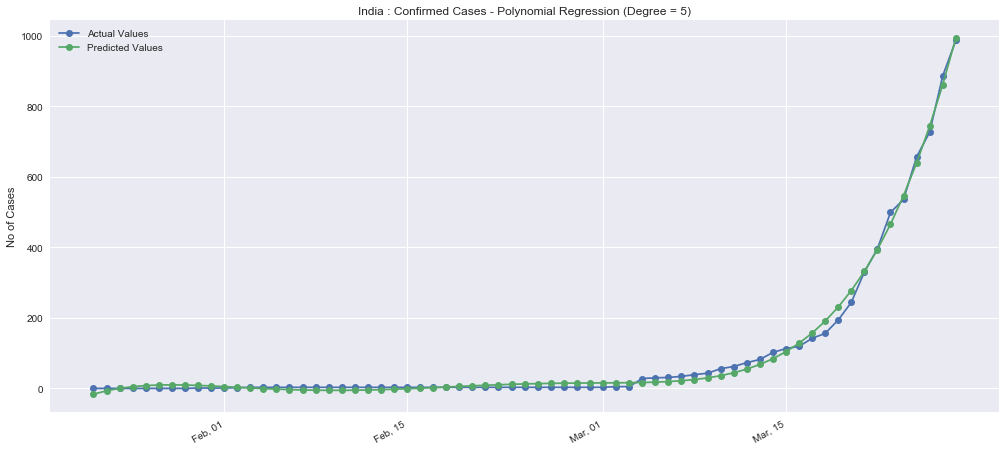

In [358]:

# Using Seaborn Style for plots.
plt.style.use('seaborn')

fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(17)
fig.autofmt_xdate()
ax.plot_date(d , y_cases, label = 'Actual Values', linestyle = 'solid')
ax.plot_date(d , lin_reg.predict(x_train_poly), label = 'Predicted Values', linestyle = 'solid')
ax.set_title('India : Confirmed Cases - Polynomial Regression (Degree = 5)')
ax.set_ylabel('No of Cases')
ax.xaxis.set_major_formatter(date_format)
ax.legend()
fig.savefig('India_conf_case')

In [352]:
times_1.shape

(85,)

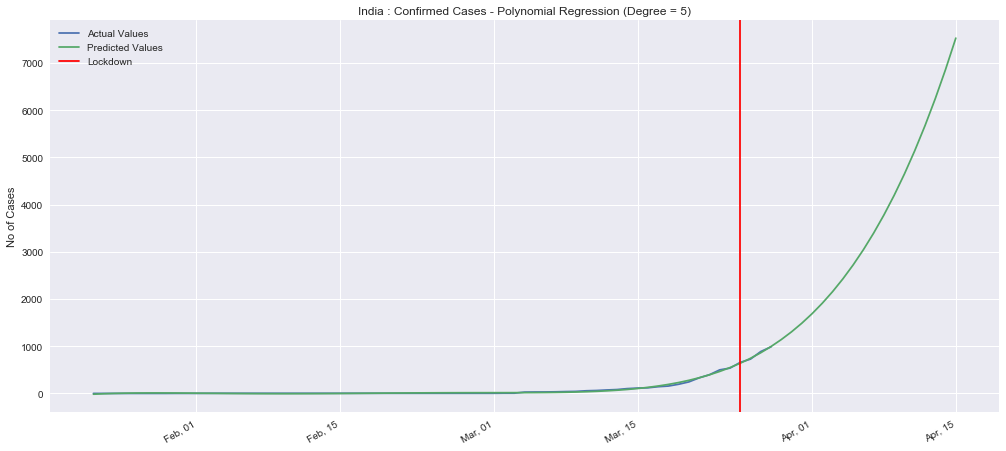

In [359]:
# generating dates using pandas
import pandas as pd

times_1 = pd.date_range(start = '2020-01-22', periods=85)

# converting to Series, list 

dates_1 = times_1.to_series().dt.date

d_1 = dates_1.tolist()

# can be used with date_plot

# Convertting, matplotlib date format 
from matplotlib import dates as dt

date_format_1 = dt.DateFormatter('%b, %d')

# Using Seaborn Style for plots.
plt.style.use('seaborn')

fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(17)
fig.autofmt_xdate()
ax.plot_date(d , y_cases, label = 'Actual Values', linestyle = 'solid', marker = None)
ax.plot_date(d_1 , lin_reg.predict(x_test_poly), label = 'Predicted Values', linestyle = 'solid', marker = None)
ax.set_title('India : Confirmed Cases - Polynomial Regression (Degree = 5)')
ax.set_ylabel('No of Cases')
ax.axvline(lock_down, color = 'r', label='Lockdown')
ax.xaxis.set_major_formatter(date_format_1)
ax.legend()
fig.savefig('India_conf_case')

In [360]:
lin_reg.predict(x_test_poly)

array([-1.64988066e+01, -6.92895418e+00,  7.58740850e-02,  4.92215023e+00,
        7.97905325e+00,  9.58005328e+00,  1.00244959e+01,  9.57918629e+00,
        8.47997355e+00,  6.93333493e+00,  5.11796002e+00,  3.18633506e+00,
        1.26632716e+00, -5.37231467e-01, -2.14095926e+00, -3.48134104e+00,
       -4.51314380e+00, -5.20783244e+00, -5.55198554e+00, -5.54571109e+00,
       -5.20106227e+00, -4.54045321e+00, -3.59507470e+00, -2.40331002e+00,
       -1.00915063e+00,  5.39388042e-01,  2.19185083e+00,  3.89692713e+00,
        5.60403506e+00,  7.26490580e+00,  8.83516774e+00,  1.02759308e+01,
        1.15553706e+01,  1.26503129e+01,  1.35478175e+01,  1.42467627e+01,
        1.47594296e+01,  1.51130863e+01,  1.53515720e+01,  1.55368813e+01,
        1.57507487e+01,  1.60962325e+01,  1.66992992e+01,  1.77104078e+01,
        1.93060937e+01,  2.16905537e+01,  2.50972292e+01,  2.97903914e+01,
        3.60667250e+01,  4.42569127e+01,  5.47272191e+01,  6.78810754e+01,
        8.41606634e+01,  

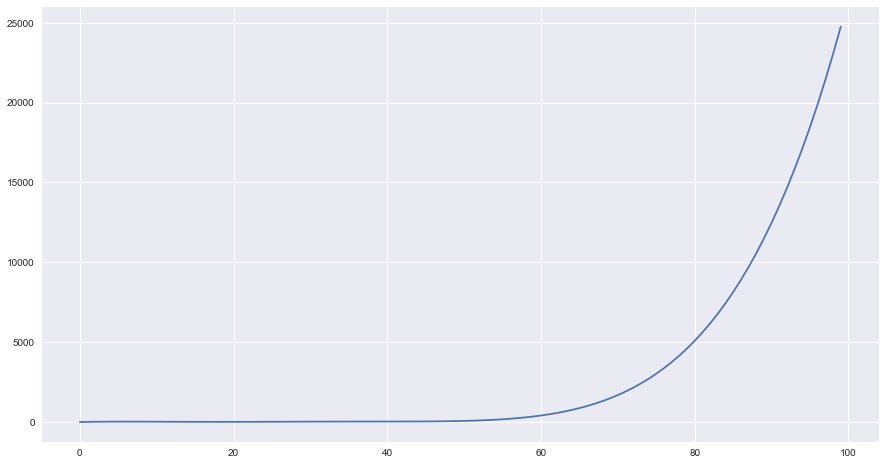

In [241]:
plt.figure(figsize=(15,8))
plt.plot(lin_reg.predict(x_test_poly))

In [279]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators =100)

In [280]:
rf.fit(x_train_poly, y_cases)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [281]:
rf.score(x_train_poly, y_cases)

0.9959351238676757

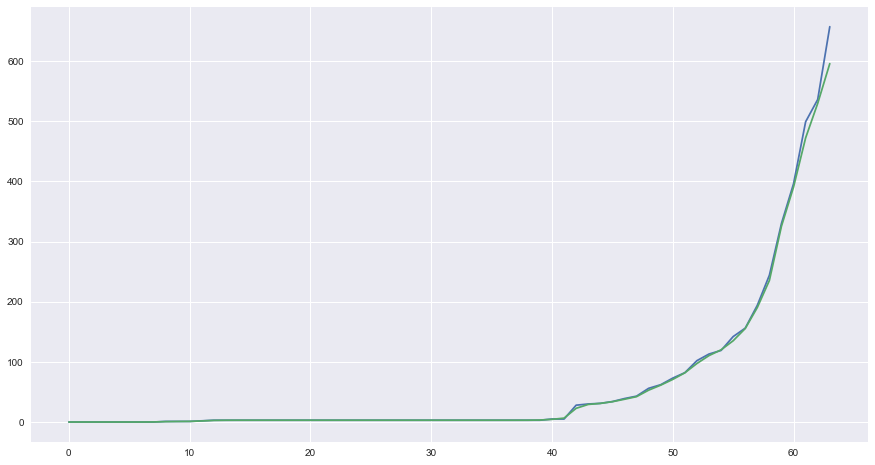

In [282]:
plt.figure(figsize=(15,8))
plt.plot(y_cases)
plt.plot(rf.predict(x_train_poly))

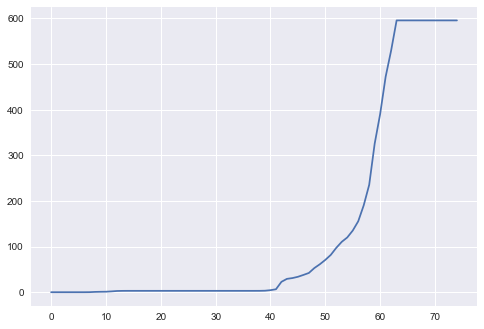

In [283]:
plt.plot(rf.predict(x_test_poly))

## 3. RandomForest Regressor
<p> With Leaky Data - Train MSE 284698.84113318456 <br>
Submission RMSLE - 1.70407 </p>
<p> Without Leaky Data - Test MSE 291078.15156607644 <br>
    Submission RMSLE - 2.18417 </p>

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#### For ConfirmedCases

In [ ]:
rf = RandomForestRegressor(n_estimators =100)
rf.fit(x_train, y_train.values.ravel())

In [ ]:
rf.score(x_train, y_train)

In [ ]:
rf.score(x_test, y_test)

In [ ]:
# Predicted Values and MSE
y_pred_train = rf.predict(x_train)
print(mean_squared_error(y_train, y_pred_train))

In [ ]:
# Training on entire set and predict values.

rf.fit(x, y_case.values.ravel())

In [ ]:
data_test_clean.shape

In [ ]:
# Predicted ConfirmedCases
rf_pred_case = rf.predict(data_test_clean)

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(rf_pred_case)

In [ ]:
x.columns[1]

In [ ]:

for i, col in enumerate(x.columns):
    print(col, rf.feature_importances_[i])


#### For Fatalities

In [ ]:
rf.fit(x, y_fatal.values.ravel())

In [ ]:
rf_pred_fatal = rf.predict(data_test_clean)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(rf_pred_fatal)

In [ ]:
# Saving to Submission.csv

submission['ConfirmedCases'] = rf_pred_case
submission['Fatalities'] = rf_pred_fatal

submission.to_csv('submission.csv', index = False)

## 5. XGBoost Regressor
<p> With Leaky Data - Train MSE <br>
Submission RMSLE - 1.695 </p>
<p> Without Leaky Data - Train MSE 10064.67200159855, 4.047602533022124 <br>
    Submission RMSLE - 2.27873 </p>

In [ ]:
import xgboost as xgb

In [ ]:
reg = xgb.XGBRegressor(n_estimators = 1000)

#### For ConfirmedCases

In [ ]:
reg.fit(x_train, y_train)

In [ ]:
reg.score(x_train, y_train)

In [ ]:
reg_y_pred = reg.predict(x_train)

In [ ]:
mean_squared_error(y_train, reg_y_pred)

In [ ]:
reg.score(x_test, y_test)

In [ ]:
# Slightly Better than Random Forest 
reg_y_test_pred = reg.predict(x_test)
mean_squared_error(y_test, reg_y_test_pred)

### Visualising predictions error on entire train set

In [ ]:
reg.fit(x, y_case)

In [ ]:
y_train_pred = reg.predict(x)

In [ ]:
plt.plot(y_case)

In [ ]:
plt.plot(y_train_pred)

In [ ]:
# 10064
mean_squared_error(y_case, y_train_pred)

In [ ]:
xgb_pred_case = reg.predict(data_test_clean)

In [ ]:
plt.plot(xgb_pred_case)

#### For Fatalities

In [ ]:
reg.fit(x, y_fatal)

In [ ]:
# Checking MSE for Fatalities

print(mean_squared_error(y_fatal, reg.predict(x)))

In [ ]:
plt.plot(reg.predict(x))

In [ ]:
plt.plot(y_fatal)

#### Predicted on Test Set

In [ ]:
xgb_pred_fatal = reg.predict(data_test_clean)

In [ ]:
plt.plot(xgb_pred_fatal)

In [ ]:
# Saving to Submission.csv

submission['ConfirmedCases'] = xgb_pred_case
submission['Fatalities'] = xgb_pred_fatal

submission.to_csv('submission.csv', index = False)